## Approach

1. This is a base model and can further be improved with various techniques and different choice of CNN architectures.
2. This model uses resnet18 pretrained model to classfify the labels.
3. The dataset contains high resolution images so we can implement image downsizing to check how the results vary along with the batch size. Lower size images can help process larger batch sizes and improve the results.
4. Predictions on test data requires probability distribution for labels, so I have used cross entropy as loss function.
5. The labels are imbalanced with one category having only 5% event rate, so I have used stratified folding for cross validation.
6. Different data augmentation methods can be tried to fine tune the model.
7. Different mini-model tweaks can also be done like using Resnet-A, Resnet-B or Resnet-C architecture.
7. Finally to squeeze more accuracy, the model can be fine tuned for the learning rate.

In [0]:
import cv2
import os
import time
import gc
import random
import imutils
import albumentations as A
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.image as mpg
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.functional import nll_loss
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from albumentations.pytorch import ToTensor
from albumentations.augmentations import transforms
from efficientnet_pytorch import EfficientNet

In [0]:
working_dir = "/content/PlantPathalogy/"
image_dir= "/content/PlantPathalogy/Images/"

train_df= pd.read_csv(working_dir+"train_sample.csv")
#test_df= pd.read_csv(working_dir+"test.csv")
sample_df= pd.read_csv(working_dir+"/test_sample.csv")

Train_87
(1365, 2048, 3)


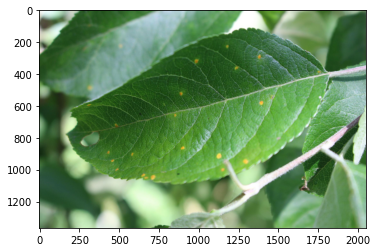

In [6]:
#show random image

random_image= random.choice(train_df['image_id'])
print(random_image)

image= mpg.imread(image_dir+random_image+".jpg")
print(image.shape)
plt.imshow(image)

In [0]:
#Training Parameters
size= 512
batch_size= 8
n_epochs= 10
lr= 1e5
seed= 42
n_folds= 5
workers= 4

In [8]:
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [9]:
train_df.tail()


,image_id,healthy,multiple_diseases,rust,scab
95,Train_95,0,1,0,0
96,Train_96,0,0,1,0
97,Train_97,0,0,1,0
98,Train_98,0,0,1,0
99,Train_99,1,0,0,0


In [0]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, train_data,transforms= None):
        
        super().__init__()
        
        self.root_dir= root_dir
        self.train_data= train_data
        self.transforms= transforms
        self.size= SIZE
        
    def __len__(self):
        
        return self.train_data.shape[0]
    

    def __getitem__(self, idx):
        
        img_id= self.train_data.iloc[idx]['image_id']
        
        
        file_path= self.root_dir+ img_id +".jpg"

        image= cv2.imread(file_path)
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        h,w,c= image.shape
        #image= image.reshape((c,h,w))

        labels= self.train_data.iloc[idx][1:].values
            
        labels= torch.from_numpy(labels.astype("uint8"))
        #print(labels.shape)
        labels= labels.unsqueeze(-1)
        if self.transforms:
            transformed= self.transforms(image= image)
            image= transformed['image']
        
        #print(image.shape, labels.shape)
        return image, labels

        

In [0]:
#Creating a custom model for training using pretrained resnet18 model

class ResnetModel(nn.Module):
    
    def __init__(self, n_classes= 4):
        
        super().__init__()
        
        self.backbone= torchvision.models.resnet18(pretrained= True)
        
        in_features= self.backbone.fc.in_features
        
        self.output= nn.Linear(in_features, n_classes)
        
    def forward(self, x):
        batch_size, H, W ,C = x.shape
        x= x.view((batch_size,C,H,W))

        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        x = F.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)
        x = F.dropout(x, 0.2, self.training)

        x = self.output(x)
        #x = F.log_softmax(x, dim= 1)

        return x

In [0]:
# Data Augmentation

'''transforms_train= transforms.Compose([transforms.RandomResizedCrop(SIZE),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(45),
                                      transforms.RandomVerticalFlip(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      transforms.ToTensor()                                  
])

transforms_valid = transforms.Compose([
    transforms.Resize(SIZE),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ToTensor(),
])'''


#Using Albumentations
transforms_train = A.Compose([transforms.RandomSizedCrop(min_max_height= (SIZE,SIZE),height= SIZE,width=SIZE, p= 1.0),
                              transforms.VerticalFlip(p=.5),
                              transforms.Normalize(p= 1.0),



    
])

transforms_valid = A.Compose([
    transforms.Resize(SIZE, SIZE, interpolation=cv2.INTER_CUBIC, p= 1.0),
    transforms.Normalize(p= 1.0),
])

### Preparing the training data

In [30]:
train_labels= train_df.iloc[:,1:].values

# For StratifiedKFold split
train_y = train_labels[:, 2] + train_labels[:, 3] * 2 + train_labels[:, 1] * 3

train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [0]:
#Loss funtion for multi-class classification, Note this is used on the logits, basically cross entropy function.

class DenseCrossEntropy(nn.Module):

    def __init__(self):
        super(DenseCrossEntropy, self).__init__()
        
        
    def forward(self, logits, labels):
        logits = logits.float()
        labels = labels.float()
        
        logprobs = F.log_softmax(logits, dim=-1)
        
        loss = -labels * logprobs
        loss = loss.sum(-1)

        return loss.mean()

In [0]:
def train_fold(n_fold, model, dataloader_train, dataloader_val, optimizer, criterion):
    
    train_fold_results= []
    #print(len(dataloader_train))
    #print(len(dataloader_val))
    for i in range(n_epochs):
        
        print("Training {} epoch".format(i))
        
        tr_loss= 0
        
        model.train()
        
        for i, (images, labels) in enumerate(dataloader_train):
            #images= batch[0]
            #labels= batch[1]
            
            images= images.to(device, dtype= torch.float)
            labels= labels.to(device, dtype= torch.float)
            #print(labels.shape)
            #print(labels.squeeze(-1).shape)
            
            output= model(images.float())
            loss= criterion(output, labels.squeeze(-1).long())
            loss.backward()
            
            tr_loss+= loss.item()
            
            optimizer.step()
            optimizer.zero_grad()
            
            
        model.eval()
        val_loss= 0
        val_labels= None
        val_preds= None
        
        for i, (images, labels) in enumerate(dataloader_val):
            
            #images= batch[0]
            #labels= batch[1]
            
            if val_labels is None:
                val_labels= labels
                
            else:
                val_labels= torch.cat((val_labels, labels), dim=0)
          
            images= images.to(device, dtype= torch.float)
            labels= labels.to(device, dtype= torch.float)
            with torch.no_grad():
                output= model(images.float())
                loss= criterion(output, labels.squeeze(-1).long())
                val_loss+= loss.item()
                
                if val_preds is None:
                    val_preds = output.data.cpu()
                    
                else:
                    val_preds= torch.cat((val_preds, output.data.cpu()), dim= 0)
       
        print("Validation loss in {} epoch is {}".format(i,val_loss/len(dataloader_val)))
        
        train_fold_results.append({
            'fold': n_fold,
            'epoch': i,
            'train_loss': tr_loss / len(dataloader_train),
            'valid_loss': val_loss / len(dataloader_val),
            'valid_score': roc_auc_score(val_labels.squeeze(-1), val_preds, average='macro'),
        })

    return val_preds, train_fold_results
                       

### Training

In [112]:
folds= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed) # Stratified spliting for class imbalance
oof_preds= np.zeros((train_df.shape[0], 4)) # to save out of fold predictions

test_dataset= PlantDataset(image_dir, sample_df)
dataloader_test= DataLoader(test_dataset, batch_size= batch_size, num_workers= workers, shuffle= False)

# Don't use shuffle with Test data

train_results= [] # to save the training results
submissions= None

for fold, (tr_idx, val_idx) in enumerate(folds.split(train_df, train_y)):
    
    train_data= train_df.iloc[tr_idx]
    train_data.reset_index(drop= True, inplace= True)
    
    val_data= train_df.iloc[val_idx]
    val_data.reset_index(drop= True, inplace= True)
    
    train_dataset= PlantDataset(image_dir,train_data)
    val_dataset= PlantDataset(image_dir,val_data)
    
    dataloader_train= DataLoader(train_dataset, batch_size= batch_size, num_workers= workers, shuffle= True)
    dataloader_val= DataLoader(val_dataset, batch_size= batch_size, num_workers= workers, shuffle= False)
    
    #Use shuffle only with training data


    model= ResnetModel(n_classes= 4)
    device= torch.device("cuda:0")
    
    model= model.to(device)
    
    plist = [{'params': model.parameters(), 'lr': 5e-5}]
    optimizer = optim.Adam(plist, lr=5e-5)
    criterion= DenseCrossEntropy()
    
    val_preds, train_fold_results= train_fold(fold, model, dataloader_train, dataloader_val, optimizer,criterion)
    print("Dfsdfs")
    oof_preds[val_idx,:]= val_preds.numpy()   #saving out of fold predictions
    
    model.eval()    # For making predictions on Test data
    test_preds= None
    
    for step, batch in enumerate(dataloader_test):

        images = batch[0]
        images = images.to(device, dtype= torch.float)

        with torch.no_grad():
            outputs = model(images.float())

            if test_preds is None:
                test_preds = outputs.data.cpu()
            else:
                test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0) #Concatinating all the test predictions
    
    
    sample_df[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_preds
    
    if submissions is None:
        submissions = test_preds / n_folds    # averaging the logits
    else:
        submissions += test_preds / n_folds
print(train_labels.shape, oof_preds.shape)
print("5 Folds roc score: {:.4f}".format(roc_auc_score(train_labels, oof_preds, average='macro')))

Training 0 epoch
Validation loss in 2 epoch is 1.5228391885757446
Training 1 epoch
Validation loss in 2 epoch is 1.6078194777170818
Training 2 epoch
Validation loss in 2 epoch is 1.4771376848220825
Training 3 epoch
Validation loss in 2 epoch is 1.4711706638336182
Training 4 epoch
Validation loss in 2 epoch is 1.3991446892420452
Training 5 epoch
Validation loss in 2 epoch is 1.2496544520060222
Training 6 epoch
Validation loss in 2 epoch is 1.322995165983836
Training 7 epoch
Validation loss in 2 epoch is 1.285378098487854
Training 8 epoch
Validation loss in 2 epoch is 1.2692557175954182
Training 9 epoch
Validation loss in 2 epoch is 1.3385910590489705
Dfsdfs
Training 0 epoch
Validation loss in 2 epoch is 1.487486203511556
Training 1 epoch
Validation loss in 2 epoch is 1.3788854678471882
Training 2 epoch
Validation loss in 2 epoch is 1.1907098293304443
Training 3 epoch
Validation loss in 2 epoch is 1.0913558999697368
Training 4 epoch
Validation loss in 2 epoch is 1.234555761019389
Trainin

### Results:
##### The model got an ROC AUC score of .9631.